# Part 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras import optimizers
from keras import initializers,regularizers

## Preprocessing


Number of total samples: 10000
Samples in the Training Set: 8000
Samples in Validation Set:2000
Length of each Sample:60


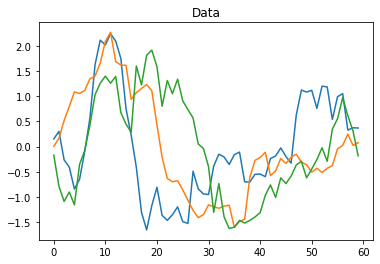

In [2]:
#filenames
str0="ts_comp_N10000"
fnamex = "DATA/x_"+str0+".csv"
fnamey = "DATA/y_"+str0+".csv"

#data
x = np.loadtxt(fnamex,delimiter=",",dtype=float)
N = len(x)

#we want to remove the average from each data
xm = x.mean(axis=1)
for n in range(N):
    x[n] = x[n] - xm[n] #data have now average 0
    
#remove the std and bring it back to 1
std = x.std(axis=1)
for n in range(N):
    x[n] = x[n] / std[n] #data have now average 0

#Labels
categ = np.loadtxt(fnamey,delimiter=",",dtype=int)
N_categ=3
y = np.zeros((N,N_categ))
for n in range(N):y[n][categ[n]] = 1 #one-hot encoding

#Training and Validation sets
perc_train = 0.8
N_train = int(N*perc_train)
N_val = N - N_train

x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]

L = len(x[0])

print(f"\nNumber of total samples: {N}\nSamples in the Training Set: {N_train}\nSamples in Validation Set:{N_val}\nLength of each Sample:{L}")

#reshape the data
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)
input_shape = (L,1)

#plot the data
plt.title("Data")
plt.plot(x[0])
plt.plot(x[1])
plt.plot(x[2])
plt.show()

# CNN architectures

We want to find the best CNN architecture to properly solve our problem with this different set of data. The general requirements of these new CNNs are that:

* They must have **only one Convolutional layer** and as many Dense layers as we want.
* They must have the **number of total trainable parameters < 600**.

In order to look for the best architecture of the CNN, we defined several models with different number of hidden layers beside the convolutional one and we performed a Grid Search to select the best parameters for each model. All the combinations of parameters that we tried were previously checked to have a number of total trainable parameters smaller than 600.

## 1-hidden layer

In [3]:
#initialize empty list of best models
best_models = []
best_scores = []

np.random.seed(12345)
reg = regularizers.l1(1e-4) #lasso regularization
ini = initializers.RandomNormal(mean=0,stddev=0.05) #initialization of the weigths
opt=optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True, decay=1e-6) #decaying learning rate

#define the model
def create_model1(neurons, filters, kernel_size):
    
    new_model = Sequential()
    new_model.add(Conv1D(filters=filters,kernel_size=kernel_size, #parameters that can be tuned
                 kernel_regularizer=reg, 
                 kernel_initializer=ini,
                 activation="relu",
                 input_shape=input_shape
                 ))
    new_model.add(AveragePooling1D(5)) #first and only pooling; from 5 numbers to 1
    new_model.add(Flatten())
    new_model.add(Dense(neurons,activation="relu"))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(N_categ,activation="softmax"))

    #compile the model
    new_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    
    return new_model

In [4]:
# create model
model1 = KerasClassifier(build_fn=create_model1, epochs=10, batch_size=10, verbose=0)

# define the grid search parameters
param_grid = [{'neurons':[10],'filters':[5],'kernel_size':[11]},
              {'neurons':[10],'filters':[5],'kernel_size':[17]},
              {'neurons':[15],'filters':[3],'kernel_size':[11]}]

grid = GridSearchCV(estimator=model1, param_grid=param_grid, n_jobs=1, cv=4, verbose=0)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#add best set of parameters to the list
best_models.append(grid_result.best_params_)
best_scores.append(grid_result.best_score_)

Best: 0.642375 using {'filters': 5, 'kernel_size': 17, 'neurons': 10}
0.589250 (0.069283) with: {'filters': 5, 'kernel_size': 11, 'neurons': 10}
0.642375 (0.035513) with: {'filters': 5, 'kernel_size': 17, 'neurons': 10}
0.559625 (0.070429) with: {'filters': 3, 'kernel_size': 11, 'neurons': 15}


## 2-hidden layer

In [5]:
#define the model
def create_model2(neuron1, neuron2, filters, kernel_size):
    
    new_model = Sequential()
    new_model.add(Conv1D(filters=filters,kernel_size=kernel_size, #parameters that can be tuned
                 kernel_regularizer=reg, 
                 kernel_initializer=ini,
                 activation="relu",
                 input_shape=input_shape
                 ))
    new_model.add(AveragePooling1D(5)) #first and only pooling; from 5 numbers to 1
    new_model.add(Flatten())
    new_model.add(Dense(neuron1,activation="relu"))
    new_model.add(Dense(neuron2,activation="relu"))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(N_categ,activation="softmax"))

    #compile the model
    new_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    
    return new_model

In [6]:
# create model
model2 = KerasClassifier(build_fn=create_model2, epochs=10, batch_size=10, verbose=0)

# define the grid search parameters
param_grid = [{'neuron1':[5],'neuron2':[5],'filters':[5],'kernel_size':[11]},
              {'neuron1':[8],'neuron2':[5],'filters':[5],'kernel_size':[11]},
              {'neuron1':[10],'neuron2':[5],'filters':[3],'kernel_size':[11]},
              {'neuron1':[15],'neuron2':[5],'filters':[5],'kernel_size':[11]}]

grid = GridSearchCV(estimator=model2, param_grid=param_grid, n_jobs=1, cv=4, verbose=0)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#add best set of parameters to the list
best_models.append(grid_result.best_params_)
best_scores.append(grid_result.best_score_)

Best: 0.670125 using {'filters': 5, 'kernel_size': 11, 'neuron1': 8, 'neuron2': 5}
0.608250 (0.030028) with: {'filters': 5, 'kernel_size': 11, 'neuron1': 5, 'neuron2': 5}
0.670125 (0.011283) with: {'filters': 5, 'kernel_size': 11, 'neuron1': 8, 'neuron2': 5}
0.595750 (0.032231) with: {'filters': 3, 'kernel_size': 11, 'neuron1': 10, 'neuron2': 5}
0.621250 (0.055854) with: {'filters': 5, 'kernel_size': 11, 'neuron1': 15, 'neuron2': 5}


## 3-hidden layer

In [7]:
#define the model
def create_model3(neuron1, neuron2, neuron3,filters, kernel_size):
    
    new_model = Sequential()
    new_model.add(Conv1D(filters=filters,kernel_size=kernel_size, #parameters that can be tuned
                 kernel_regularizer=reg, 
                 kernel_initializer=ini,
                 activation="relu",
                 input_shape=input_shape
                 ))
    new_model.add(AveragePooling1D(5)) #first and only pooling; from 5 numbers to 1
    new_model.add(Flatten())
    new_model.add(Dense(neuron1,activation="relu"))
    new_model.add(Dense(neuron2,activation="relu"))
    new_model.add(Dense(neuron3,activation="relu"))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(N_categ,activation="softmax"))

    #compile the model
    new_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    
    return new_model

In [8]:
# create model
model3 = KerasClassifier(build_fn=create_model3, epochs=10, batch_size=10, verbose=0)

param_grid = [{'neuron1':[8],'neuron2':[8],'neuron3':[5],'filters':[5],'kernel_size':[11]},
              {'neuron1':[10],'neuron2':[8],'neuron3':[5],'filters':[3],'kernel_size':[11]},
              {'neuron1':[10],'neuron2':[8],'neuron3':[8],'filters':[3],'kernel_size':[11]}]
              
grid = GridSearchCV(estimator=model3, param_grid=param_grid, n_jobs=1, cv=4, verbose=0)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
 
#add best set of parameters to the list
best_models.append(grid_result.best_params_)
best_scores.append(grid_result.best_score_)

Best: 0.587125 using {'filters': 3, 'kernel_size': 11, 'neuron1': 10, 'neuron2': 8, 'neuron3': 8}
0.568750 (0.061120) with: {'filters': 5, 'kernel_size': 11, 'neuron1': 8, 'neuron2': 8, 'neuron3': 5}
0.543750 (0.036826) with: {'filters': 3, 'kernel_size': 11, 'neuron1': 10, 'neuron2': 8, 'neuron3': 5}
0.587125 (0.060744) with: {'filters': 3, 'kernel_size': 11, 'neuron1': 10, 'neuron2': 8, 'neuron3': 8}


## 4-hidden layers

In [9]:
#function that creates the model with tunable parameters
def create_model4(neurons1,neurons2,neurons3,neurons4,filters,kernel_size):
    
    new_model = Sequential()
    new_model.add(Conv1D(filters=filters,kernel_size=kernel_size, #parameters that can be tuned
                 kernel_regularizer=reg, 
                 kernel_initializer=ini,
                 activation="relu",
                 input_shape=input_shape
                 ))

    new_model.add(AveragePooling1D(5)) #first and only pooling; from 5 numbers to 1
    new_model.add(Flatten())
    
    new_model.add(Dense(neurons1,activation="relu"))
    new_model.add(Dense(neurons2,activation="relu"))
    new_model.add(Dense(neurons3,activation="relu"))
    new_model.add(Dense(neurons4,activation="relu"))
    
    new_model.add(Dropout(0.2))
    new_model.add(Dense(N_categ,activation="softmax"))
    
    #compile the model
    new_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    
    return new_model

In [10]:
#grisearch of best combination of parameters

# create model
model4 = KerasClassifier(build_fn=create_model4, epochs=10, batch_size=10, verbose=0)

# define the grid search parameters
param_grid = [{'neurons1':[5],'neurons2':[5],'neurons3':[5],'neurons4':[5],'filters':[5],'kernel_size':[11]},
              {'neurons1':[10],'neurons2':[10],'neurons3':[5],'neurons4':[5],'filters':[3],'kernel_size':[11]},
              {'neurons1':[10],'neurons2':[5],'neurons3':[5],'neurons4':[5],'filters':[3],'kernel_size':[11]},
              {'neurons1':[5],'neurons2':[5],'neurons3':[5],'neurons4':[5],'filters':[3],'kernel_size':[11]},
              {'neurons1':[10],'neurons2':[10],'neurons3':[5],'neurons4':[5],'filters':[3],'kernel_size':[7]},
              {'neurons1':[8],'neurons2':[8],'neurons3':[8],'neurons4':[8],'filters':[3],'kernel_size':[7]},
              {'neurons1':[8],'neurons2':[5],'neurons3':[5],'neurons4':[5],'filters':[5],'kernel_size':[11]}]

grid = GridSearchCV(estimator=model4, param_grid=param_grid, n_jobs=1, cv=4, verbose=0)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#add best set of parameters to the list
best_models.append(grid_result.best_params_)
best_scores.append(grid_result.best_score_)

print(best_models)
print(best_scores)

Best: 0.617500 using {'filters': 5, 'kernel_size': 11, 'neurons1': 5, 'neurons2': 5, 'neurons3': 5, 'neurons4': 5}
0.617500 (0.046919) with: {'filters': 5, 'kernel_size': 11, 'neurons1': 5, 'neurons2': 5, 'neurons3': 5, 'neurons4': 5}
0.588500 (0.063866) with: {'filters': 3, 'kernel_size': 11, 'neurons1': 10, 'neurons2': 10, 'neurons3': 5, 'neurons4': 5}
0.542625 (0.052080) with: {'filters': 3, 'kernel_size': 11, 'neurons1': 10, 'neurons2': 5, 'neurons3': 5, 'neurons4': 5}
0.532500 (0.059320) with: {'filters': 3, 'kernel_size': 11, 'neurons1': 5, 'neurons2': 5, 'neurons3': 5, 'neurons4': 5}
0.555750 (0.051755) with: {'filters': 3, 'kernel_size': 7, 'neurons1': 10, 'neurons2': 10, 'neurons3': 5, 'neurons4': 5}
0.534625 (0.048236) with: {'filters': 3, 'kernel_size': 7, 'neurons1': 8, 'neurons2': 8, 'neurons3': 8, 'neurons4': 8}
0.558750 (0.062530) with: {'filters': 5, 'kernel_size': 11, 'neurons1': 8, 'neurons2': 5, 'neurons3': 5, 'neurons4': 5}
[{'filters': 5, 'kernel_size': 17, 'neuron

After having found the best sets of parameters for the four different CNN architectures, we compared their performances and plotted the results.

The optimal parameters that we derived are:

* 1-layer: total trainable parameters=533
    * hidden layers=(10)
    * filters=5
    * kernel_size=17
      
* 2-layer: total trainable parameters=531
    * hidden layers=(8,5)
    * filters=5
    * kernel_size=11
           
* 3-layer: total trainable parameters=603
    * hidden layers=(10,8,8)
    * filters=3
    * kernel_size=11
* 4-layer: total trainable parameters=591
    * hidden layers=(10,5,5,5)
    * filters=3
    * kernel_size=11


In [11]:
batch_size = 250
epochs = 250

#define models with best parameters
model1=create_model1(**best_models[0])
model2=create_model2(**best_models[1])
model3=create_model3(**best_models[2])
model4=create_model4(**best_models[3])

#fit the models
fit1 = model1.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit2 = model2.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit3 = model3.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit4 = model4.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

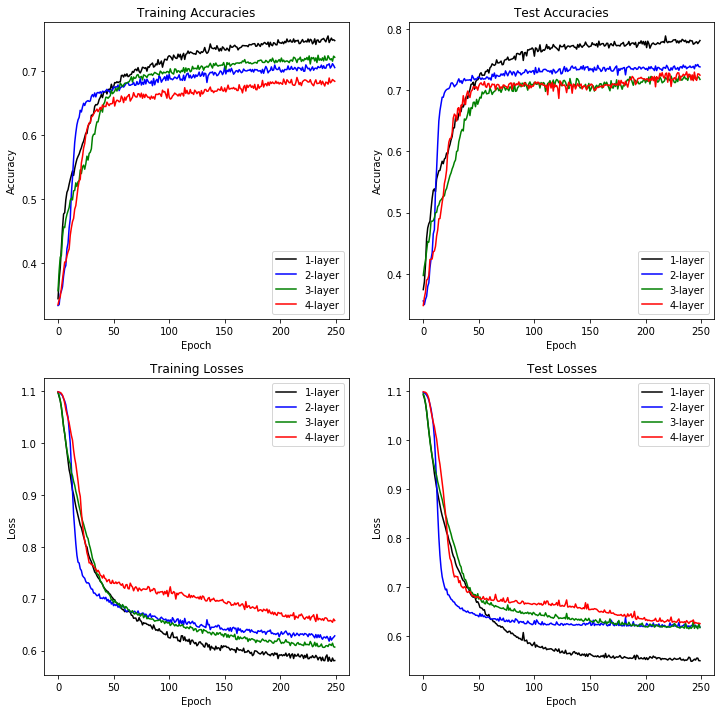

In [12]:
#evaluate performances
score1 = model1.evaluate(x_val, y_val, verbose=0)
score2 = model2.evaluate(x_val, y_val, verbose=0)
score3 = model3.evaluate(x_val, y_val, verbose=0)
score4 = model4.evaluate(x_val, y_val, verbose=0)

#plot
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(12,12))

#Training Accuracy
ax[0,0].plot(fit1.history['accuracy'],color='black')
ax[0,0].plot(fit2.history['accuracy'],color='blue')
ax[0,0].plot(fit3.history['accuracy'],color='green')
ax[0,0].plot(fit4.history['accuracy'],color='red')
ax[0,0].set_title("Training Accuracies")
ax[0,0].set_ylabel('Accuracy')
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend(['1-layer', '2-layer', '3-layer', '4-layer'], loc='best')

#Test Accuracy
ax[0,1].plot(fit1.history['val_accuracy'],color='black')
ax[0,1].plot(fit2.history['val_accuracy'],color='blue')
ax[0,1].plot(fit3.history['val_accuracy'],color='green')
ax[0,1].plot(fit4.history['val_accuracy'],color='red')
ax[0,1].set_title("Test Accuracies")
ax[0,1].set_ylabel('Accuracy')
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend(['1-layer', '2-layer', '3-layer', '4-layer'], loc='best')

#Training Loss
ax[1,0].plot(fit1.history['loss'],color='black')
ax[1,0].plot(fit2.history['loss'],color='blue')
ax[1,0].plot(fit3.history['loss'],color='green')
ax[1,0].plot(fit4.history['loss'],color='red')
ax[1,0].set_title("Training Losses")
ax[1,0].set_ylabel('Loss')
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend(['1-layer', '2-layer', '3-layer', '4-layer'], loc='best')

#Test Loss
ax[1,1].plot(fit1.history['val_loss'],color='black')
ax[1,1].plot(fit2.history['val_loss'],color='blue')
ax[1,1].plot(fit3.history['val_loss'],color='green')
ax[1,1].plot(fit4.history['val_loss'],color='red')
ax[1,1].set_title("Test Losses")
ax[1,1].set_ylabel('Loss')
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend(['1-layer', '2-layer', '3-layer', '4-layer'], loc='best')

plt.show()    

## Conclusion

From the images that we plotted, the most performing CNN architecture happens to be the one with **only one hidden layer** after the first convolutional one. The parameters that lead us to the best results are:

* Hidden Layer=(10)
* Filters=5
* Kernel_size=17

For this specific CNN configuration we obtained:
* Test Accuracy: 0.781000018119812
* Test Loss: 0.549453854560852

With 533 total trainable parameters.

In [14]:
best_model=model1